In [1]:
from slugify import slugify
import numpy as np
import pandas as pd
import scipy.stats


import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
from pymc import Gamma, Poisson, Exponential, Model

import json

# import dcs
# import priors
import pgamma

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
ref_prior = (1, 100)

# location data: characteristices of the sensors
# make sure that the sensor (location names) are slugged
# that is the strings are either lower case or hyphens
bi = pd.read_csv("dc_locations.csv")
bi["sensor"] = bi["sensor"].map(lambda x: slugify(x))

# the guesses from the students
guessed = pd.read_csv('guesses.csv')

# The aggregated data and survey results for any feature (lake, river, river-basin or city)
# can be accessed through the pgamma module. 
report_name="Lac Léman"
feature="feature"
feature_name="lac-leman"

# retrieve the current data and the most common codes for the region of interest
# there is no need to provide a data source. It is included in the module. 
# from the module we request the complete report for Lac Léman from IQAASL porject
# as well as a list of the most common codes for the lake
report_leman, codes = pgamma.get_most_common_and_aggregated_feature_report(
    report_name=report_name, pg=feature, pgn=feature_name)
codes.remove("G117")
# get the report of all the codes from the lake data
#  this is is an N*D array. he column names are the first row of the array
# so drop the first row and rename the columns and limit the results
# to the codes in "codes"
dr = report_leman.make_report_code_summary()
di = pd.DataFrame(data=dr[1:], columns=dr[0])
# the summary data of the most common codes from Lac Léman
# between March 2020 and May 2021
mcommon = di[di.Code.isin(codes)]

# lac leman has three distinct regions, Haut lac, Grand lac and Petite lac
grand_lac = ['Tolochenaz',
     'Bourg-en-Lavaux', 
     'Morges', 
     'Allaman', 
     'Lausanne', 
     'Saint-Sulpice (VD)', 
     'Préverenges', 
     'Rolle',
    ]
haut_lac = ['La Tour-de-Peilz', 'Vevey', 'Montreux',  'Saint-Gingolph']
petite_lac = ['Gland', 'Versoix', 'Genève']

# All survey records (including IQAASL)
eix = pd.read_csv("ei_uptotdate.csv")
eix["date"] = pd.to_datetime(eix["date"])

# the data prior to the sample date
ei = eix[eix["date"] < "2022-10-01"]
# mask for the most common codes
code_mask = (ei.code.isin(codes))
# the data prior to the sample data
# only the codes of interest
d = ei[code_mask].copy()

log started


## Implementing the model

The model defined in poisson_gamma.ipynb is modified and run against using the most common codes. Using the same tests as the prior model. The output is formatted to .JSON and implemented in a web app.

Here we start defining the minimum requirements on the server side. The model checks and final comparison versus the students guesses can be found in implement.ipynb

The web application can be found at hammerdirt.ch or plagespropres.ch

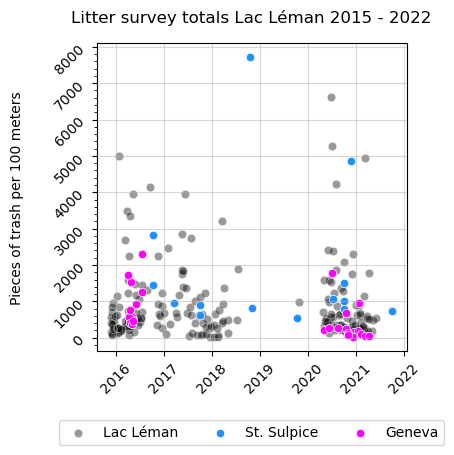

In [2]:
# the survey totals for the lake and Saint Sulpice
# the sum in pcs/100m of each sample since 2015
sp_prior = ei[(ei.city ==  'Saint-Sulpice (VD)')].copy()
g_prior = ei[(ei.city ==  'Genève')].copy()
cdt = sp_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
gdt = g_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
daily_totals = ei.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
fig, ax = plt.subplots(figsize=(4, 4))

daily_totals["date"] = pd.to_datetime(daily_totals["date"])
cdt["date"] =  pd.to_datetime(cdt["date"])
gdt["date"] =  pd.to_datetime(gdt["date"])

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", color="black", alpha=0.4, label="Lac Léman", ax=ax)
sns.scatterplot(data=cdt, x="date", y="pcs_m", color="dodgerblue", label="St. Sulpice", ax=ax)
sns.scatterplot(data=gdt, x="date", y="pcs_m", color="magenta", label="Geneva", ax=ax)
ax.set_ylabel("Pieces of trash per 100 meters", labelpad=20)
ax.set_xlabel(" ")
ax.set_title("Litter survey totals Lac Léman 2015 - 2022", fontsize=12, pad=15)
ax.tick_params(axis="both", which="both", labelsize=10, rotation=45)
ax.legend(bbox_to_anchor=(0.5,-.2), loc="upper center", ncol=3)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(which='major', axis='both', alpha=0.5)
plt.show()

### The most common objects under consideration

In [3]:
mcommon

,Code,Description,N pieces,pcs/m,% of total,Fail rate
4,G200,"Glass drink bottles, pieces",510,0.03,0.0,0.582
5,G23,Lids unidentified,262,0.02,0.0,0.582
8,G89,Plastic construction waste,584,0.06,0.0,0.663
10,G31,Lollypop sticks,237,0.03,0.0,0.663
17,G27,Cigarette filters,3116,0.47,0.0,0.949
19,G112,Industrial pellets (nurdles),1387,0.00,0.0,0.469
20,G30,"Food wrappers; candy, snacks",1679,0.22,0.0,0.959
25,G67,Industrial sheeting,1058,0.09,0.0,0.776
26,G95,Cotton bud/swab sticks,1112,0.12,0.0,0.816
28,G24,Lid/cap rings from plastic bottles/containers,349,0.04,0.0,0.735


### Summary of prior knowledge

We assume that the beach litter survey results are **vectors** that describe the interaction/exchange of trash (all sizes > 0mm) between the survey location and the body of water it borders. *Body of water* refers to areas of reduced current flow in a river basin. For example lake Geneva to the Rhône or Bielersee to the Aare. Therefore, the magnitude of the interaction/exchange is quantified by the rate component of the vector that describes the interaction.  

1. The survey results represent the minimum possible value for an object. It is certain that not all objects that were present at a location were indetified and counted. Furtthermore, objects that are found can be misidentified or the wrong code applied to the record upon data entry.

2. There is a relationship to the number of objects suspended in the body of water and the number of objects that are counted and identitfied in the strand-line at a survey. The number of objects in suspension is unknown.

3. Objects in suspension are trasnported according to the direction of the river basin, surface currents, wind currents and meteorological events. The magnitude of the exchange of objects between the shoreline and the body of water is also influenced by local topography. The magnitued of this exchange is unknown for the lake in general nor for any location in particular.

4. Each location or beach produces/emitts particles that are exchanged with the lake. Those particles get transported according to 3. 

5. Storm water drains, streams, rivers and canals ( hydrologic inputs ) are sources of particles in suspension. The number and size of hydrologic inputs is a factor in the number of particles in suspension for a  body of water.

6. The three different regions of Lac Léman are characterized by different currents, average depth and resident time. 

The magnitude of the *trash* vector on the beach is the result of many interactions. One possible method to forecasting results could include quantifying each interaction term. This would be helpfull information but is not strictly required. From a resource perspective this would require that three additional sources of information (for each quantified interaction) be maintained and accessible for each location so that forecasting could be accomplished. None of which currently exist at a required precision level for any specific location. **The question is about the magnitude of the *trash* vector (the value of pieces/meter) and not any other attribute, for this there is direct evidence.** The shortcomings or bias of this evidence is summarized in 1, pieces/meter describes the results of the exchanges in 2-6.

The Negative Binomial distribution has been suggested by WRU and the JRC when calculating trend lines or identifying extreme values from a dataset ( JRC ). The Generalized Linear Model (GLM) method proposed by WRU uses the survey totals and group totals to determine trend lines, with the recomendation to use objects that are indentified frequently. The example in the report is Single Use Plastics (SUPS). This method does not exclude any survey results and is constrained geographically. 

#### Models and priors

**Prior data:** The method proposed by WRU is attractive because of the properties of the NB and its use in evaluating count data in many other fields. To the model proposed by WRU we add a definition of objects that are *identified frequently* as any object that was found in at least 50% of the surveys or any object with a cumulative total that places them in the top ten most abundant. This method considers both the frequency and proportion of an object in relation to the total and provides a standard definition for "identified frequently".

**Model:** Given conditions 2-5 we assume that the survey results for the most common objects are NB distributed with parameters $\alpha$ and $\lambda$. $A$ is Exponentialy distributed with parameter $i$ and $\Lambda$ is the result of the interaction of the region, municpality and the location on the survey value $Y$ for a an object. The intercept  and all interaction terms are truncated to $x \geq 0$.

$$
\begin{aligned} 
Y  &\sim NB(\lambda, \alpha) \\
\alpha &\sim Exponential(i) \\
\lambda &= B + B_{city}X * B_{sensor}X * B_{object}X \\
B_{intercept} &\sim  HalfNormal(\mu, \sigma), \mu \geq 0 \\
B_{city} &\sim TruncatedNormal(\mu, \sigma) \\
B_{sensor} &\sim TruncatedNormal(\mu, \sigma) \\
B_{object} &\sim TruncatedNormal(\mu, \sigma) \\
\end{aligned}
$$

The intended purpose of the model is to allow end users to consult current and predicted values for any number of planning purposes. This includes planning holiday weekends or designing a process that is supposed to reduce trash in the water for a region or body of water. Our conditions of success are focussed on practicallity and implementation. The testing of the model and the results from those tests should be easy to consult and understand. The definitive test should always be a direct comparison between what was found and the forecast. The initial test period should be as long as the baseline collection period. In this case one year.

**Conditions of success:**

1. On average have a better prediction rate than a random guess
2. The forecast describes a compromise between the city and the subregion
3. Predicted values are reasonable compared to historical results
4. The forecast is sensitive to the addition of new information


### Use Cases

#### Limiting exposure

The goal is to identify locations where the probability of an encountering an object or a group of objects is lowest. Regional, municpal and individual survey results are considered. If $P$ is the probability of finding an object then this would be the location where $1-P$ is greatest. 

#### Finding a source

The goal is to identify potential sources for an object or a group of objects. This also helps identify objects where location does not play a dominant role in the value of $P$. For some objects the value of $P$ for a range of values of $X$ should be fairly close in different of the location given the result from chapter 20 of the IQAASL report.

#### Finding success stories

The value of $P$ for a range of $X$ will change as data enters. If $P$ for a given value trends down then this indicates that conditions at the location are likely improving and that the improvement is observable.



### Summary of results by region and subregion

The mean pcs/100m of the most common objects indentified for the period 2020-2021. The variance of the survey results increase with the required geographical precision of the assessment. This relationship is in part due to the decreasing number of samples per region or sub region, ie. there are 250  surveys for the lake and only 15 for Saint Sulpice. The average pcs/100m at Saint Sulpice is double that of the lake, while the average of the grand-lac is very close to the lake.

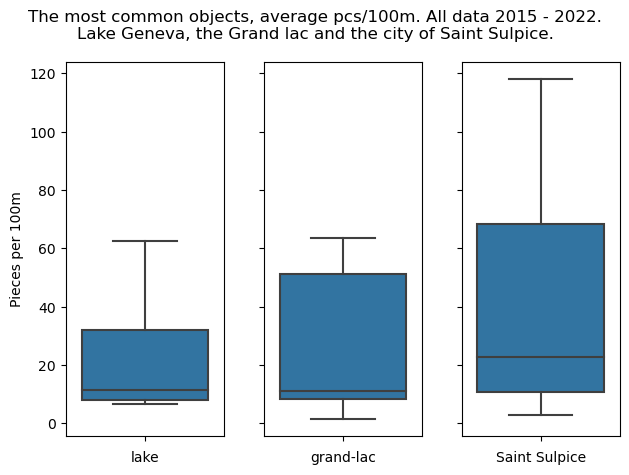

In [4]:
def add_group(x, haut_lac, petite_lac, grand_lac):
    
    if x in haut_lac:
        d = "haut-lac"
    elif x in petite_lac:
        d = "petite-lac"
    elif x in grand_lac:
        d = "grand-lac"
    else:
        return x
    return d
    
# recall that ei is all the data prior to the sample date
# mean_pcode is the average result in pcs_m for each code
mean_pcode = d.groupby("code").pcs_m.mean()



# assign the mean and calculate the difference of each result
# to the mean for the object (the mean sum of squared diffrences)
d["mean_c"] = d["code"].map(lambda x: mean_pcode.loc[x])
d["mean_diff"] = d["pcs_m"] - d["mean_c"]
d["mean_diff_sqrd"] = d["mean_diff"]**2
d["root_mean_diff"] = d["mean_diff_sqrd"]**1/2
d["group"] = "lake"
d["group"] = d["city"].map(lambda x: add_group(x, haut_lac, petite_lac, grand_lac))

# the survey results for the most common codes at the 
# different aggregate levels
done = d.groupby("code", as_index=False)["pcs_m"].mean()
dtwo = d[d.group == "grand-lac"].groupby("code", as_index=False)["pcs_m"].mean()
dthree = d[d.city == 'Saint-Sulpice (VD)'].groupby("code", as_index=False)["pcs_m"].mean()

fig, ax = plt.subplots(1,3, sharey=True)
xlabels = ["lake", "grand-lac", "Saint Sulpice"]

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

for i, anax in enumerate([ax1, ax2, ax3]):
    anax.set_xlabel(xlabels[i])

sns.boxplot(data=done, y="pcs_m",  showfliers=False, ax=ax1)
sns.boxplot(data=dtwo, y="pcs_m",  showfliers=False, ax=ax2)
sns.boxplot(data=dthree, y="pcs_m",  showfliers=False, ax=ax3)

for anax in [ax2, ax3]:
    anax.set_ylabel(" ")

title_one = "The most common objects, average pcs/100m. All data 2015 - 2022."
title_two = "Lake Geneva, the Grand lac and the city of Saint Sulpice."

ax1.set_ylabel("Pieces per 100m")
plt.suptitle(f"{title_one}\n{title_two}")
plt.tight_layout()
plt.show()

In [5]:
fsummaries = f"""

Summary lake:
{done.pcs_m.describe()}

Summary grand-lac:
{dtwo.pcs_m.describe()}

Summary Saint Sulpice:
{dthree.pcs_m.describe()}

        """
print(fsummaries)



Summary lake:
count     23.000000
mean      32.517478
std       43.112852
min        6.548000
25%        7.955269
50%       11.421687
75%       31.961847
max      138.600000
Name: pcs_m, dtype: float64

Summary grand-lac:
count     23.000000
mean      38.502694
std       54.140661
min        1.576271
25%        8.330508
50%       11.258621
75%       51.169492
max      219.600000
Name: pcs_m, dtype: float64

Summary Saint Sulpice:
count     23.000000
mean      66.606418
std       97.635158
min        2.857143
25%       10.607143
50%       22.857143
75%       68.192308
max      345.733333
Name: pcs_m, dtype: float64

        


### Implementing the model in PyMC

In [6]:
dcaps = d[d.code.isin(["G21", "G24", "G23"])].copy()
dnocaps = d[~d.code.isin(["G21", "G24", "G23"])].copy()

these_cols = dcaps.columns
dcaps["code"] = "Gcaps"

dtest = pd.concat([dnocaps, dcaps])


columns = ["pcs_m","quantity", "group", "city", "code", "sensor"]

workData = dtest[columns].copy()
codes = workData.code.unique()
workData.reset_index(inplace=True, drop=True)

workData.head()

,pcs_m,quantity,group,city,code,sensor
0,6.0,4,haut-lac,La Tour-de-Peilz,G10,anarchy-beach
1,14.0,10,haut-lac,La Tour-de-Peilz,G100,anarchy-beach
2,0.0,0,haut-lac,La Tour-de-Peilz,G112,anarchy-beach
3,3.0,2,haut-lac,La Tour-de-Peilz,G177,anarchy-beach
4,4.0,3,haut-lac,La Tour-de-Peilz,G178,anarchy-beach


In [7]:
code = "G95"

maskOne = workData.group == "grand-lac"
wd = workData[(maskOne)&(workData.code == code)].copy()
wd.reset_index(inplace=True, drop=True)

group, glabels = pd.factorize(wd.group)
components, comp_labels = pd.factorize(wd.code)
sensors, sensor_labels = pd.factorize(wd.sensor)
cities, city_labels = pd.factorize(wd.city)

coords = {"component":comp_labels, "city":city_labels, "group": glabels, "sensors":sensor_labels, "obs_id":wd.index.values}

with pm.Model(coords=coords) as glmNBR:
    
    comp_idx = pm.Data("codes", components, dims="obs_id", mutable=True)
    sensor_idx = pm.Data("sensor", sensors, dims="obs_id", mutable=True)
    city_idx = pm.Data("city", cities, dims="obs_id", mutable=True)
    observed = pm.ConstantData("obs", wd.pcs_m.values, dims="obs_id")    
   
    comp = pm.TruncatedNormal("c", mu=0, sigma=100, lower=0, dims="component")
    city = pm.TruncatedNormal("cit", mu=0, sigma=100, lower=0, dims="city")
    sensor = pm.TruncatedNormal("s", mu=0, sigma=100, lower=0, dims="sensors")
    an_int = pm.HalfNormal("an_int", sigma=5, dims="obs_id")
    
        
    line = an_int +  comp[comp_idx]*sensor[sensor_idx]*city[city_idx]
    # mu = pm.Normal("mu", mu=line, sigma=1)
    alpha = pm.Exponential("alpha", lam=0.5, dims="obs_id")    
    
    found = pm.NegativeBinomial("found", mu=line, alpha=alpha, observed=observed)
    
with glmNBR:
    sampled = pm.sample(1000, tune=2000)
    pm.sample_posterior_predictive(sampled ,extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 83 seconds.


In [8]:
def make_data_for_inference(d, code, region):
    maskOne = (d.group == region)
    maskTwo = (d.code == code)
    dx = d[maskOne & maskTwo]
    dx.reset_index(inplace=True, drop=True)
    
    return dx

def make_coordinates(d):
    components, comp_labels = pd.factorize(d.code)
    cities, city_labels = pd.factorize(d.city)
    sensors, sensor_labels = pd.factorize(d.sensor)
    
    coordinates = {
        "component":comp_labels,
        "sensors":sensor_labels,
        "city":city_labels,
        "obs_id":d.index.values}
    
    return coordinates, cities, components, sensors

def retrieve_posterior_dist_city(post, this_d, city):
    city_dims = this_d[(this_d.city == city)].index.values
    dx = [*np.ravel(post.posterior_predictive.sel({'found_dim_0': city_dims}).found)]
    
    return dx

def retrieve_posterior_dist_sensor(post, this_d, sensor):
    sensor_dims = this_d[(this_d.sensor == sensor)].index.values
    dx = [*np.ravel(post.posterior_predictive.sel({'found_dim_0': sensor_dims}).found)]
    
    return dx

def collect_posterior_dists(post, this_d, cities):
    
    results = {}
    for city in cities:
        d = retrieve_posterior_dist_city(post, this_d, city)
        results.update({city:d})
    
    return results
def collect_posterior_dists_sensor(post, this_d, sensors):
    
    results = {}
    for sensor in sensors:
        d = retrieve_posterior_dist_sensor(post, this_d, sensor)
        results.update({sensor:d})
    
    return results

def run_model(d, coords, component_index, city_index, sensor_index):
    
    with pm.Model(coords=coords) as glmNBRCity:    
        comp_idx = pm.Data("codes", component_index, dims="obs_id", mutable=True)
        sensor_idx = pm.Data("sensor", sensor_index, dims="obs_id", mutable=True)
        city_idx = pm.Data("city", city_index, dims="obs_id", mutable=True)
        observed = pm.ConstantData("obs", d.pcs_m.values, dims="obs_id")    

        comp = pm.TruncatedNormal("c", mu=0, sigma=100, lower=0, dims="component")
        city = pm.TruncatedNormal("cit", mu=0, sigma=100, lower=0, dims="city")
        sensor = pm.TruncatedNormal("s", mu=0, sigma=100, lower=0, dims="sensors")
        an_int = pm.HalfNormal("an_int", sigma=5, dims="obs_id")


        line = an_int +  comp[comp_idx]*sensor[sensor_idx]*city[city_idx]
        alpha = pm.Exponential("alpha", lam=0.5, dims="obs_id")    

        found = pm.NegativeBinomial("found", mu=line, alpha=alpha, observed=observed)
        sampled = pm.sample(1000, tune=2000)
        pm.sample_posterior_predictive(sampled ,extend_inferencedata=True, random_seed=rng)
        
    return sampled
  

In [9]:
def posterior_predicitive_region(d, codes, region):
    
    post_results = {}
    for code in codes:
        print(code)
        this_d = make_data_for_inference(d, code, region)
        coords, city_index, component_index, sensor_index = make_coordinates(this_d)
        post = run_model(this_d, coords, component_index, city_index, sensor_index)
        post_d = collect_posterior_dists_sensor(post, this_d, coords["sensors"])
        post_results.update({code:post_d})
    return post_results

In [10]:
region = "petite-lac"
codes = workData.code.unique()
cities = ['Gland', 'Versoix', 'Genève']
petite_lac = posterior_predicitive_region(workData, codes, region)

G10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 97 seconds.


G100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 66 seconds.


G112


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 64 seconds.


G177


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 65 seconds.


G178


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 81 seconds.


G200


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 65 seconds.


G25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 64 seconds.


G27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 103 seconds.


G30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 116 seconds.
The acceptance probability does not match the target. It is 0.7067, but should be close to 0.8. Try to increase the number of tuning steps.


G31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 102 seconds.
The acceptance probability does not match the target. It is 0.6586, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.692, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6658, but should be close to 0.8. Try to increase the number of tuning steps.


G32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 67 seconds.


G33


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 96 seconds.


G35


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 70 seconds.


G67


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 112 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


G70


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 79 seconds.


G74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 77 seconds.


G89


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 111 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


G95


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 131 seconds.
The acceptance probability does not match the target. It is 0.7108, but should be close to 0.8. Try to increase the number of tuning steps.


Gfoam


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 130 seconds.


Gfrags


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 139 seconds.
The acceptance probability does not match the target. It is 0.6491, but should be close to 0.8. Try to increase the number of tuning steps.


Gcaps


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 150 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6428, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6785, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6546, but should be close to 0.8. Try to increase the number of tuning steps.


In [11]:
region = "haut-lac"
cities = ['La Tour-de-Peilz', 'Vevey', 'Montreux',  'Saint-Gingolph']
haut_lac = posterior_predicitive_region(workData, codes, region)
# with open('haut_lac.json', 'w') as outfile:
#     json.dump(haut_lac, outfile, default=np_encoder)

G10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 129 seconds.


G100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 125 seconds.


G112


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 142 seconds.


G177


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 124 seconds.


G178


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 109 seconds.


G200


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 116 seconds.


G25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 103 seconds.


G27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 129 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5443, but should be close to 0.8. Try to increase the number of tuning steps.


G30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 127 seconds.


G31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 116 seconds.


G32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 107 seconds.


G33


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 108 seconds.


G35


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 114 seconds.


G67


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 118 seconds.


G70


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 112 seconds.


G74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 119 seconds.


G89


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 121 seconds.


G95


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 120 seconds.


Gfoam


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 122 seconds.


Gfrags


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 150 seconds.


Gcaps


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 191 seconds.


In [12]:
region = "grand-lac"
cities = ['Tolochenaz',
     'Bourg-en-Lavaux', 
     'Morges', 
     'Allaman', 
     'Lausanne', 
     'Saint-Sulpice (VD)', 
     'Préverenges', 
     'Rolle',
    ]
grand_lac = posterior_predicitive_region(workData, codes, region)

G10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 89 seconds.


G100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 93 seconds.


G112


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 97 seconds.


G177


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 92 seconds.


G178


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 89 seconds.


G200


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 101 seconds.


G25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 80 seconds.


G27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 104 seconds.


G30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 102 seconds.


G31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 103 seconds.


G32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 95 seconds.


G33


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 96 seconds.


G35


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 97 seconds.


G67


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 94 seconds.


G70


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 83 seconds.


G74


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 97 seconds.


G89


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 78 seconds.


G95


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 114 seconds.


Gfoam


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 99 seconds.


Gfrags


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 112 seconds.


Gcaps


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, cit, s, an_int, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 110 seconds.


In [15]:
codedf = pd.read_csv("new_codes.csv")
newCode = {
    "code":"Gcaps",
    "material":" Plastic",
    "description":"plastic lids for bottles all types",
    "groupname":"food and drink", 
    "parent_code":"Parent code"
}
codedf.set_index("code", inplace=True)
codedf.loc["Gcaps",:]=newCode


codeMap = codedf[["description"]]
codeMap.loc["Gcaps"]["description"]

'plastic lids for bottles all types'

In [18]:
workData.head()

,pcs_m,quantity,group,city,code,sensor
0,6.0,4,haut-lac,La Tour-de-Peilz,G10,anarchy-beach
1,14.0,10,haut-lac,La Tour-de-Peilz,G100,anarchy-beach
2,0.0,0,haut-lac,La Tour-de-Peilz,G112,anarchy-beach
3,3.0,2,haut-lac,La Tour-de-Peilz,G177,anarchy-beach
4,4.0,3,haut-lac,La Tour-de-Peilz,G178,anarchy-beach


In [19]:
from statistics import median, mean, stdev

# codes.remove("G117")
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()
def get_1000_samples(post, wd, sensors, codes, region):   
    
    results = []
    for code in codes:
        observed = make_data_for_inference(wd, code, region)
        code_r = {code:{}}
        
        for sensor in sensors:
            # predicted
            di = list([*post[code][sensor]])
            pmean = float(mean(di))
            std = float(stdev(di))
            pmedian = float(median(di))
            qtile = [.10, .20, .8, .9]
            ptiles = np.quantile(di, qtile)
            
          
            # observed            
            obs_sensor = observed[(observed.sensor == sensor)].pcs_m.values
            obs_mean = float(mean(obs_sensor))
            obs_median = float(median(obs_sensor))
            
            obs_sensor_len = len(obs_sensor)
            r = {
                "code": code,
                "description":codeMap.loc[code]["description"],
                "sensor":sensor,
                "mean":pmean,
                "std":std,
                "median":pmedian,
                "10%":ptiles[0],
                "20%":ptiles[1],
                "80%":ptiles[2],
                "90%":ptiles[3],
                "obs_mean": obs_mean,
                "obs_median":obs_median,
                "obs_n_samps":obs_sensor_len
                }
            results.append(r)
    
    return results


sensors = workData[workData.group == "petite-lac"].sensor.unique()
petiteLac = get_1000_samples(petite_lac, workData, sensors, codes, "petite-lac")
with open('petite_lac_bu.json', 'w') as outfile:
    json.dump(petiteLac, outfile, default=np_encoder)

In [21]:



def make_regional_summary(codes, sensors, posterior, region, qtile=qtile):
    regional = []
    for code in codes:
        results = []
        for sensor in sensors:
            d = posterior[code][sensor]
            results += d
        r_mean = float(np.mean(results))
        r_median = float(np.median(results))
        r_std = float(np.std(results))
        ptiles = np.quantile(results, qtile)
        r = {
            "region":region,
            "code": code,
            "mean":r_mean,
            "std":r_std,
            "median":r_median,
            "10%":ptiles[0],
            "20%":ptiles[1],
            "80%":ptiles[2],
            "90%":ptiles[3],
        }
        
        regional.append(r)
    return regional
    
    

city = []

def make_municipal_summary(codes, cities, posterior, region, qtile=qtile):
    
    city = []
    for acity in cities:
        ss = workData[workData.city == acity].sensor.unique()
        for code in codes:
            results = []
            for s in ss:
                d = posterior[code][s]
                results += d
            r_mean = float(np.mean(results))
            r_median = float(np.median(results))
            r_std = float(np.std(results))
            ptiles = np.quantile(results, qtile)
            r = {
                "region":region,
                "city":acity,
                "code": code,
                "mean":r_mean,
                "std":r_std,
                "median":r_median,
                "10%":ptiles[0],
                "20%":ptiles[1],
                "80%":ptiles[2],
                "90%":ptiles[3],
                }

            city.append(r)
    return city           

In [22]:
region = "petite-lac"
sensors = workData[workData.group == region].sensor.unique()
cities = workData[(workData.group == region)].city.unique()
qtile = [.10, .20, .8, .9]

regional = make_regional_summary(codes, sensors, petite_lac, region, qtile=qtile)
municipal = make_municipal_summary(codes, cities, petite_lac, region, qtile=qtile)
with open('petite_lac_summary_bu.json', 'w') as outfile:
    json.dump(regional, outfile, default=np_encoder)
    
with open('petite_lac_municipal_bu.json', 'w') as outfile:
    json.dump(municipal, outfile, default=np_encoder)

In [23]:
region = "grand-lac"
sensors = workData[workData.group == region].sensor.unique()
cities = workData[(workData.group == region)].city.unique()
regional = make_regional_summary(codes, sensors, grand_lac, region, qtile=qtile)
municipal = make_municipal_summary(codes, cities, grand_lac, region, qtile=qtile)
with open('grand_lac_summary_bu.json', 'w') as outfile:
    json.dump(regional, outfile, default=np_encoder)
    
with open('grand_lac_municipal_bu.json', 'w') as outfile:
    json.dump(municipal, outfile, default=np_encoder)

In [24]:
region = "haut-lac"
sensors = workData[workData.group == region].sensor.unique()
cities = workData[(workData.group == region)].city.unique()
regional = make_regional_summary(codes, sensors, haut_lac, region, qtile=qtile)
municipal = make_municipal_summary(codes, cities, haut_lac, region, qtile=qtile)
with open('haut_lac_summary_bu.json', 'w') as outfile:
    json.dump(regional, outfile, default=np_encoder)
    
with open('haut_lac_municipal_bu.json', 'w') as outfile:
    json.dump(municipal, outfile, default=np_encoder)

In [25]:
sensors = workData[workData.group == "grand-lac"].sensor.unique()

grandLac= get_1000_samples(grand_lac, workData, sensors, codes, "grand-lac")
with open('grand_lac_bu.json', 'w') as outfile:
    json.dump(grandLac, outfile, default=np_encoder)

In [26]:
sensors = workData[workData.group == "haut-lac"].sensor.unique()

hautLac= get_1000_samples(haut_lac, workData, sensors, codes, "haut-lac")
with open('haut_lac_bu.json', 'w') as outfile:
    json.dump(hautLac, outfile, default=np_encoder)